# Hückel matrix Benzene
The first step is to obtain the Hückel matrix for Benzene. This is formed with the $p_z$-orbitals of the six carbon atoms.  
\begin{equation}
H_{hückel} = \begin{bmatrix}
    \alpha & \beta & 0 & 0 &  \beta\\
    \beta & \alpha & \beta & 0 & 0 \\
    0 & \beta & \alpha & \beta & 0 \\
    0 & 0 & \beta & \alpha & \beta \\
    \beta & 0 & 0 & \beta & \alpha
\end{bmatrix}
\end{equation}
$\alpha$ represents the energy present on a carbon atom. $\beta$ represents the overlap integration between two adjacent $p_z$-orbitals. 
First we import some package that will be necessary for this project. 


In [1]:
import numpy as np
from pyscf import gto, scf
from sympy import symbols, Matrix, simplify, pprint, solve
import matplotlib.pyplot as plt

This is the function that can make the matrix for the required system. In our case benzene. 

In [2]:
# Deze functie dient om een huckel marix op te stellen. Werkt voor ring als voor een lineaire keten zoals butadieen.
# pi-systemen
def huckel_matrix(number_atoms, alpha, beta, configuration = 'ring'):
    huckel_matrix = np.zeros((number_atoms, number_atoms))
    for i in range(number_atoms):
        for j in range(number_atoms):
            if i == j:
                huckel_matrix[i][j] = alpha
            elif abs(i - j) == 1:
                huckel_matrix[i][j] = beta
    
    if configuration == 'ring':
        huckel_matrix[0][number_atoms-1], huckel_matrix[number_atoms-1][0] = beta, beta
    return  huckel_matrix

In [3]:
alpha_ = -1.5
beta_ = -0.5
matrix = huckel_matrix(number_atoms=6, alpha=alpha_, beta=beta_)
print(matrix)

[[-1.5 -0.5  0.   0.   0.  -0.5]
 [-0.5 -1.5 -0.5  0.   0.   0. ]
 [ 0.  -0.5 -1.5 -0.5  0.   0. ]
 [ 0.   0.  -0.5 -1.5 -0.5  0. ]
 [ 0.   0.   0.  -0.5 -1.5 -0.5]
 [-0.5  0.   0.   0.  -0.5 -1.5]]


In [4]:

alpha, beta = symbols('alpha beta')
huckel_matrix = Matrix([
        [alpha, beta, 0, 0, 0, beta],
        [beta, alpha, beta, 0, 0, 0],
        [0, beta, alpha, beta, 0, 0],
        [0, 0, beta, alpha, beta, 0],
        [0, 0, 0, beta, alpha, beta],
        [beta, 0, 0, 0, beta, alpha]
    ])

determinant_expr = huckel_matrix.det()
pprint(huckel_matrix)
print('This is the determinant of the matrix')
print(determinant_expr)

eigeninfo = huckel_matrix.eigenvects()
list_eigval = np.array([])
list_multi = np.array([])
for eigenvalue, multiplicity, eigenvectors in eigeninfo: 
    list_multi = np.append(list_multi, multiplicity)
    for i, eigenvector in enumerate(eigenvectors):
        list_eigval = np.append(list_eigval, eigenvalue)
list_eigval = np.flipud(list_eigval)
print(list_eigval)
print(list_multi)

⎡α  β  0  0  0  β⎤
⎢                ⎥
⎢β  α  β  0  0  0⎥
⎢                ⎥
⎢0  β  α  β  0  0⎥
⎢                ⎥
⎢0  0  β  α  β  0⎥
⎢                ⎥
⎢0  0  0  β  α  β⎥
⎢                ⎥
⎣β  0  0  0  β  α⎦
This is the determinant of the matrix
alpha**6 - 6*alpha**4*beta**2 + 9*alpha**2*beta**4 - 4*beta**6
[alpha + 2*beta alpha + beta alpha + beta alpha - beta alpha - beta
 alpha - 2*beta]
[1. 2. 2. 1.]


The next step is to find the eigenvalues and eigenvectors of this matrix. 

In [5]:
def solve_huckel_matrix(matrix):
    eigenvalues, eigenvectors = np.linalg.eig(matrix)
    eigenvectors = eigenvectors.round(6)
    eigenvalues = eigenvalues.round(6)

    # Sort eigenvalues and corresponding eigenvectors
    sort_indices = np.argsort(eigenvalues)
    eigenvalues = eigenvalues[sort_indices]
    eigenvectors = eigenvectors[:, sort_indices]
    return eigenvalues, eigenvectors



In [6]:
eigenvalues, eigenvectors = solve_huckel_matrix(matrix)
print(eigenvalues, eigenvectors, list_eigval, list_multi)

[-2.5 -2.  -2.  -1.  -1.  -0.5] [[ 0.408248  0.57735   0.163829 -0.57735   0.046966  0.408248]
 [ 0.408248  0.288675 -0.397533  0.288675 -0.521826 -0.408248]
 [ 0.408248 -0.288675 -0.561362  0.288675  0.47486   0.408248]
 [ 0.408248 -0.57735  -0.163829 -0.57735   0.046966 -0.408248]
 [ 0.408248 -0.288675  0.397533  0.288675 -0.521826  0.408248]
 [ 0.408248  0.288675  0.561362  0.288675  0.47486  -0.408248]] [alpha + 2*beta alpha + beta alpha + beta alpha - beta alpha - beta
 alpha - 2*beta] [1. 2. 2. 1.]


Next step is to make the eigenvectors with same eigenvalues orthogonal to each other. The first function uses Gramm-Schmidt to do this (but fails now). The second function translate a set of functions in orthogonal ones.

In [7]:
#This function doesn't work yet, orthogonalization_2 works
def orthogonalization(eigenvalues, eigenvectors):
    dic_eigenvalues_index = dict()
    for index, eigenvalue in enumerate(eigenvalues):
        
        if eigenvalue.round(2) not in dic_eigenvalues_index:
            dic_eigenvalues_index[eigenvalue.round(2)] = [index]
            
        else:
            dic_eigenvalues_index[eigenvalue.round(2)].append(index)
    print(dic_eigenvalues_index)
    for eigenvalue, indexen in dic_eigenvalues_index.items():
        if len(indexen) > 1:
            eig_1 = eigenvectors[:, indexen[0]]
            eig_2 = eigenvectors[:, indexen[1]]
            # Gramm-Schmidt procedure
            eig_2 = eig_1 - (np.dot(eig_1, eig_2)/ np.dot(eig_1, eig_2)) * eig_2
            
            print(np.dot(eig_1, eig_2))
            # de eigenvector terug op zijn plaats zetten
            eigenvectors[:, indexen[1]] = eig_2
    return eigenvectors

In [8]:
def orthogonalization_2(eigenvalues, eigenvectors):
    dic_eigenvalues_index = dict()
    for index, eigenvalue in enumerate(eigenvalues):
        
        if eigenvalue.round(2) not in dic_eigenvalues_index:
            dic_eigenvalues_index[eigenvalue.round(2)] = [index]
            
        else:
            dic_eigenvalues_index[eigenvalue.round(2)].append(index)
            
    for eigenvalue, indexen in dic_eigenvalues_index.items():
        if len(indexen) > 1:
            eig_1 = eigenvectors[:, indexen[0]]
            eig_2 = eigenvectors[:, indexen[1]]
            matrix = np.column_stack((eig_1, eig_2))

            # Voer de QR-decompositie uit
            q, r = np.linalg.qr(matrix)

            # De georthogonaliseerde vectoren zijn de kolommen van de Q-matrix
            orthogonal_v1 = q[:, 0]
            orthogonal_v2 = q[:, 1]
            eigenvectors[:, indexen[0]] = orthogonal_v1 
            eigenvectors[:, indexen[1]] = orthogonal_v2
    return eigenvectors

In [9]:
eigenvectors = orthogonalization_2(eigenvalues, eigenvectors).round(6)
print(eigenvectors)

[[ 0.408248 -0.57735   0.       -0.57735   0.        0.408248]
 [ 0.408248 -0.288675 -0.5       0.288675 -0.5      -0.408248]
 [ 0.408248  0.288675 -0.5       0.288675  0.5       0.408248]
 [ 0.408248  0.57735  -0.       -0.57735  -0.       -0.408248]
 [ 0.408248  0.288675  0.5       0.288675 -0.5       0.408248]
 [ 0.408248 -0.288675  0.5       0.288675  0.5      -0.408248]]


Next function is for the normalisation of the eigenvectors but with in this case the eigenvectors are already orthonormal. 

In [10]:
# normalisation is not required here. Already normalized. 
def normaliseer(eigenvectors):
    for index, eigenvector in enumerate(eigenvectors):
        eigenvectors[index] = eigenvector * (np.dot(eigenvector, eigenvector))**(-1/2)
    return eigenvectors

After obtaining the different eigenvalues and eigenvectors, we are going to obtain a picture of the different molecular orbitals. This molecular orbitals will be expressed in the set of $p_z$-orbitals.

In [11]:

def plotting_of_the_system(eigenvalues, eigenvectors, num_atoms):
    eigenvectors = eigenvectors.T

    # Plot de moleculaire orbitalen
    fig, axs = plt.subplots(1, len(eigenvalues), figsize=(15, 3))
    
    for i in range(len(eigenvalues)):
        ax = axs[i]
        
        # Plot de benzeenring
        benzene_x = np.cos(2 * np.pi / num_atoms * np.arange(num_atoms))
        benzene_y = np.sin(2 * np.pi / num_atoms * np.arange(num_atoms))
        ax.plot(benzene_x, benzene_y, linestyle='-', color='grey')
        ax.plot([benzene_x[-1], benzene_x[0]], [benzene_y[-1], benzene_y[0]], linestyle='-', color='grey')
        # Plot de atoomcoëfficiënten als gekleurde bollen
        for j in range(num_atoms):
            c = eigenvectors[i, j]

            if c > 0:
                color = 'blue'
            else:
                color = 'red'

            size = abs(c) * 300  # Schaal de grootte van de bol op basis van de coëfficiënt
            ax.scatter(benzene_x[j], benzene_y[j], s=size, marker='o', color=color, zorder=2)

        ax.set_title(f'MO {i + 1}\nEnergy: {eigenvalues[i]:.2f} eV')

        ax.axis('off')
    # Stel het algehele plot-titel in
    plt.suptitle('Molecular Orbitals - Benzene - Hückel')

    # Zorg ervoor dat de subplots niet overlappen
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    # Toon de plot
    plt.show()


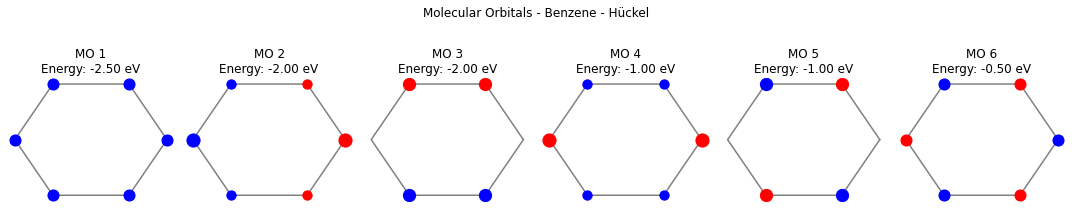

[-2.5 -2.  -2.  -1.  -1.  -0.5]


In [12]:
plotting_of_the_system(eigenvalues, eigenvectors, 6)
print(eigenvalues)

[[-0.408248  0.57735   0.        0.57735   0.       -0.408248]
 [-0.408248  0.288675  0.5      -0.288675  0.5       0.408248]
 [-0.408248 -0.288675  0.5      -0.288675 -0.5      -0.408248]
 [-0.408248 -0.57735   0.        0.57735   0.        0.408248]
 [-0.408248 -0.288675 -0.5      -0.288675  0.5      -0.408248]
 [-0.408248  0.288675 -0.5      -0.288675 -0.5       0.408248]]


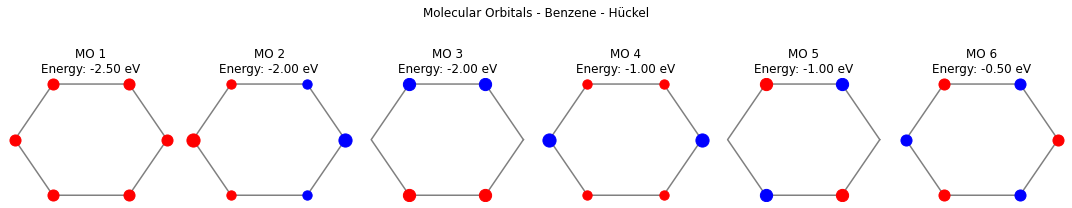

In [13]:
sigma_h = -1*np.eye(6)

eigenvectors_sigma_h = sigma_h @ eigenvectors
print(eigenvectors_sigma_h)
plotting_of_the_system(eigenvalues, eigenvectors_sigma_h, 6)

In [14]:
all_alfa_beta = []
for i in range(6):
    eigenvector = eigenvectors[:, i]
    alfa_beta = [0, 0]
    for i in range(6):
        for j in range(6):
            if i == j:
                alfa_beta[0] += eigenvector[i] * eigenvector[j]
            elif abs(i-j) in [1, 5]:
                alfa_beta[1] += eigenvector[i] * eigenvector[j]
    all_alfa_beta.append(alfa_beta)

all_alfa_beta = np.array(all_alfa_beta).round(5)

alpha, beta = symbols('alpha beta')
for i in all_alfa_beta:
    pprint(f'eigenvalue: {i[0]}{alpha} {i[1]}{beta}')


eigenvalue: 1.0alpha 2.0beta
eigenvalue: 1.0alpha 1.0beta
eigenvalue: 1.0alpha 1.0beta
eigenvalue: 1.0alpha -1.0beta
eigenvalue: 1.0alpha -1.0beta
eigenvalue: 1.0alpha -2.0beta


[-2.5, -2.0, -1.0, -0.5]
-2.5 1
-2.0 2
-1.0 2
-0.5 1


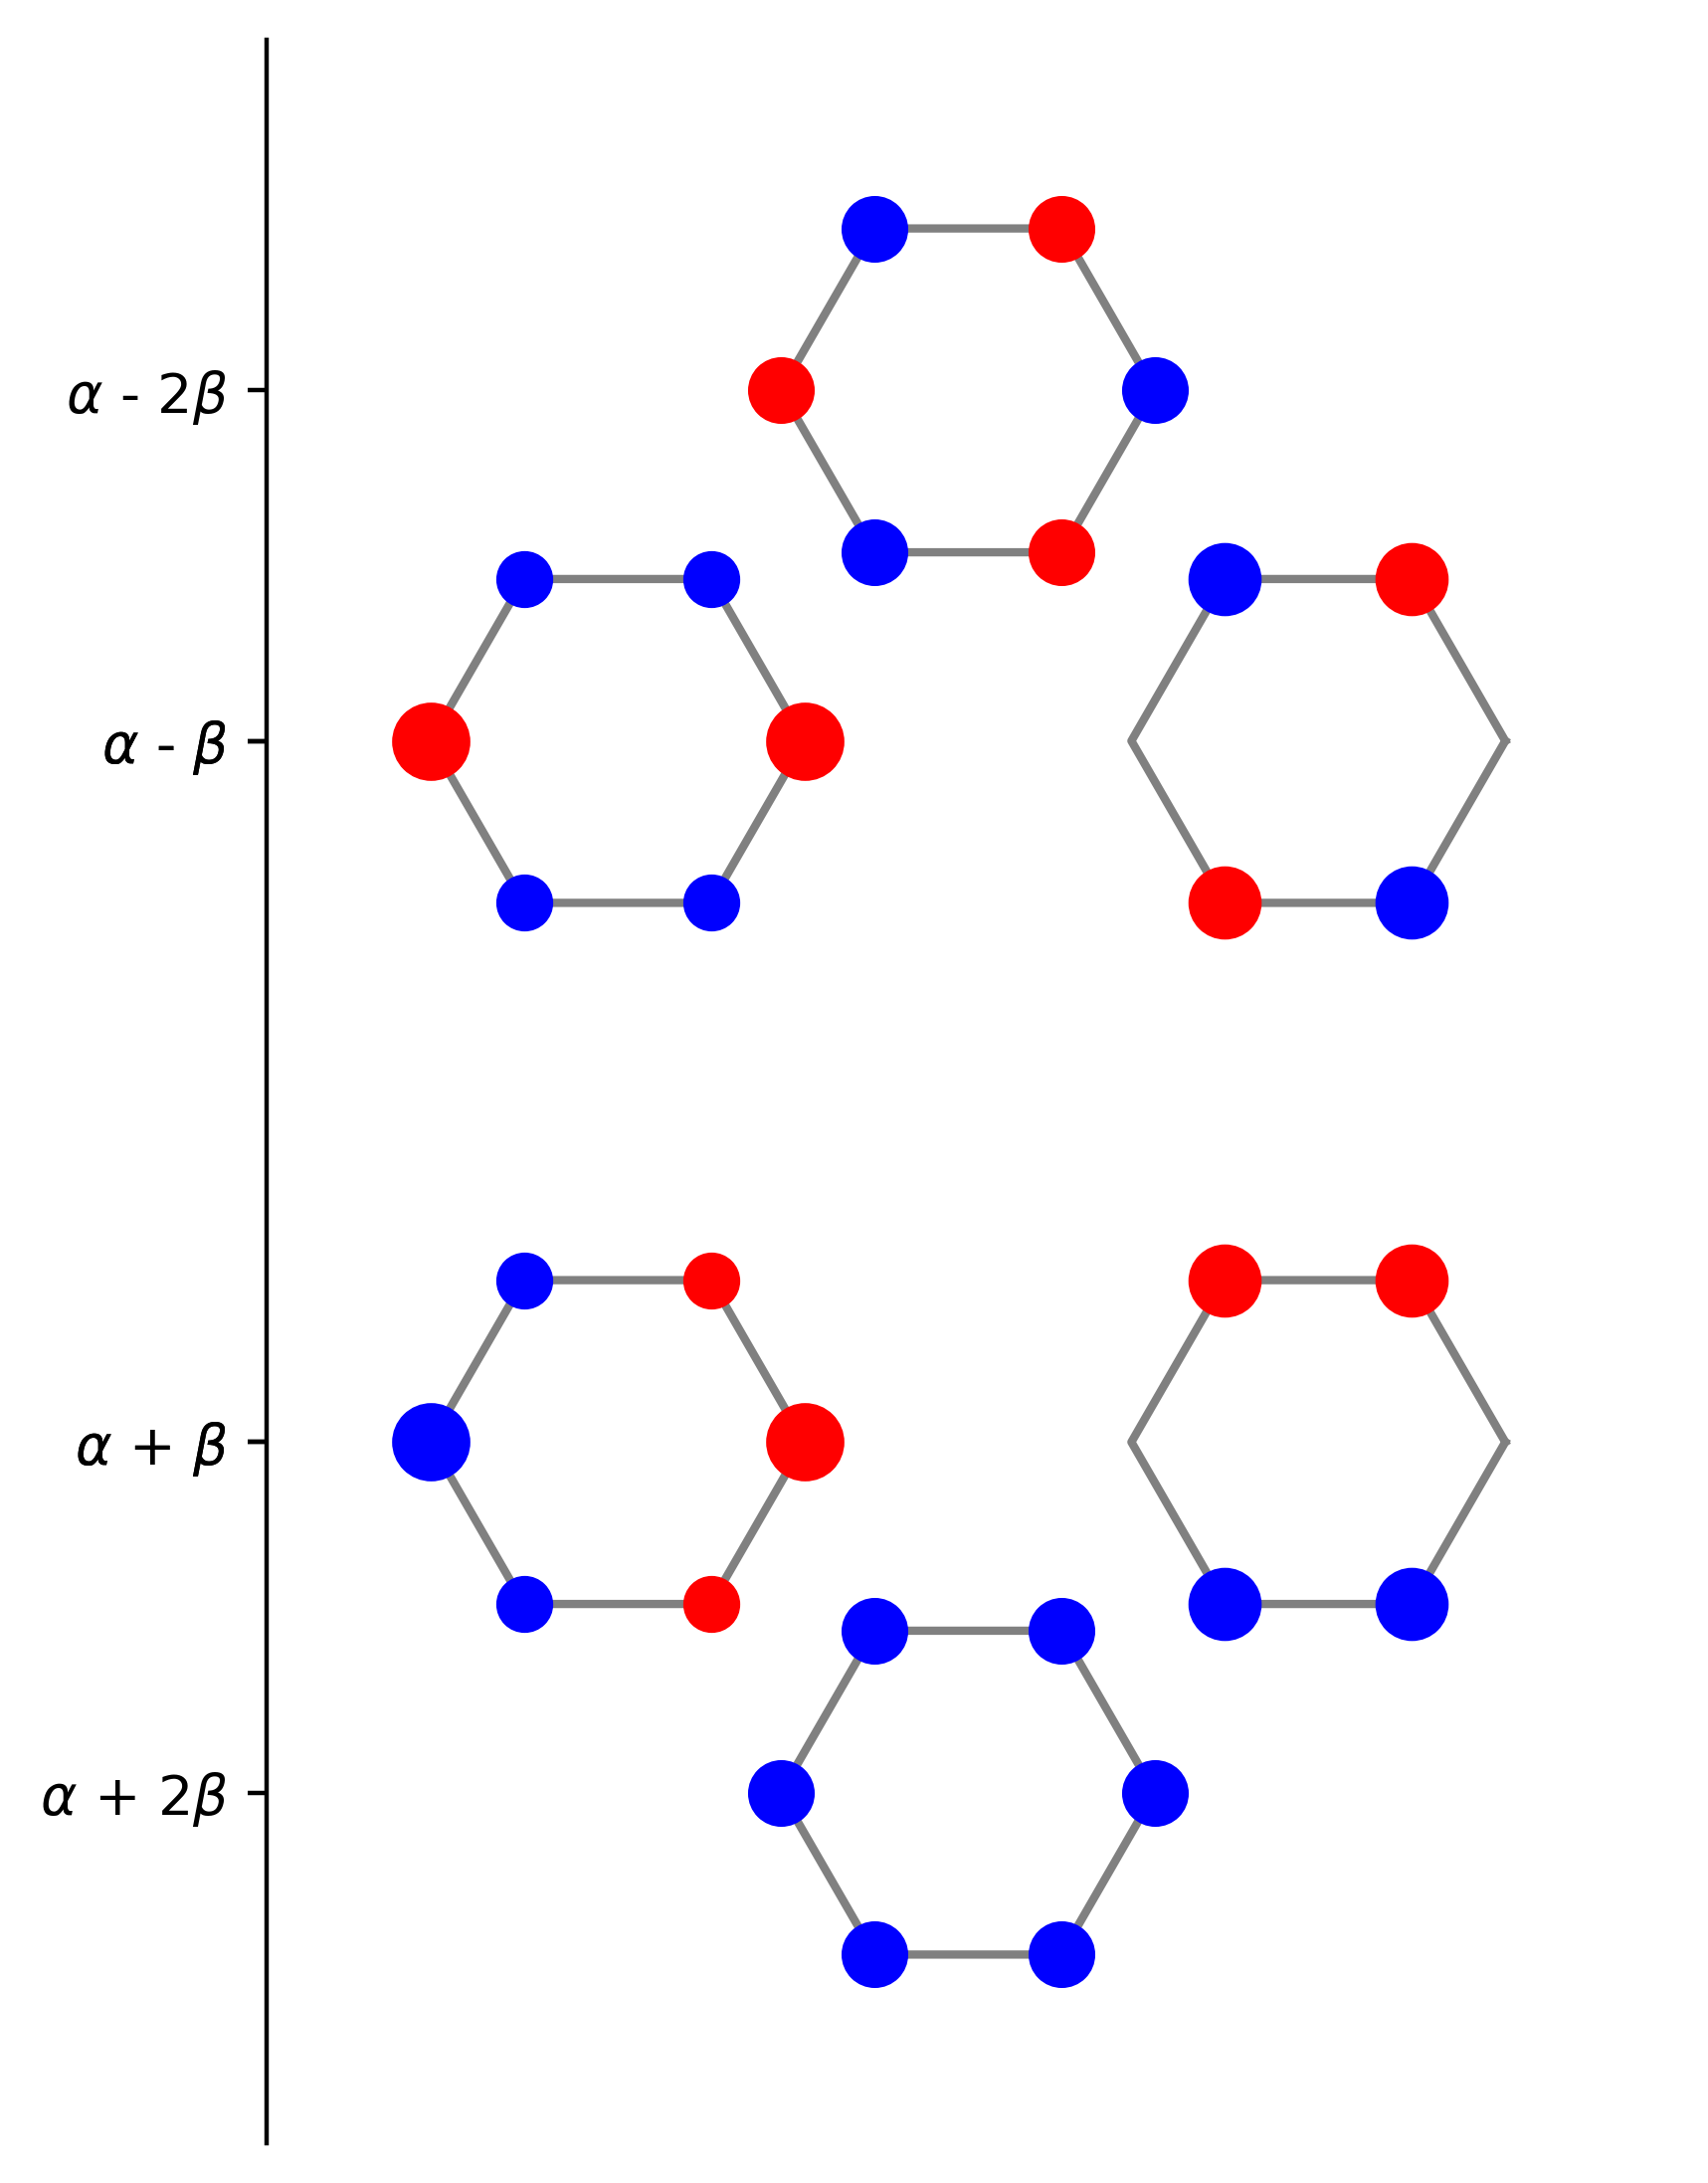

<Figure size 24000x16000 with 0 Axes>

In [15]:
def convert_list_to_latex(expressions):
    latex_list = []

    for expression in expressions:
        terms = str(expression).split()
        latex_representation = ""

        for term in terms:
            if "*" in term:
                factors = term.split("*")
                for factor in factors:
                    if factor.isalpha():
                        latex_representation += rf'$\{factor}$'
                    else:
                        latex_representation += rf'{factor}'
            elif term.isalpha():
                latex_representation += rf'$\{term}$'
            else:
                latex_representation += term

            latex_representation += " "

        latex_list.append(latex_representation.strip())

    return latex_list

# Voorbeeldgebruik

latex_list = convert_list_to_latex(list_eigval)

# Maak het plot zonder x-as, y-as en kader
fig, ax = plt.subplots(figsize=(5, 7), dpi=400)
ax.spines['left'].set_visible(2)
ax.spines['right'].set_linewidth(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xticks([])  # Verwijder x-ticklabels

ax.set_ylim(min(eigenvalues) - abs(beta_), max(eigenvalues) + abs(beta_))
ax.set_xlim(-1, 1)
# Voeg aangepaste y-aslabels toe met gegenereerde LaTeX-notaties
ax.set_yticks(eigenvalues)
ax.set_yticklabels(latex_list)
num_atoms = 6
counter = 0

eigval_to = sorted(list(set(eigenvalues)))
print(eigval_to)
for value, multi in zip(eigval_to, list_multi):
    multi = int(multi)
    print(value, multi)
    if multi == 1:
        y_coords = value
        x_coords = 0
        

        benzene_x = np.cos(2 * np.pi / num_atoms * np.arange(num_atoms))/abs(2.5*alpha_) + x_coords
        benzene_y = np.sin(2 * np.pi / num_atoms * np.arange(num_atoms))/abs(2.5*alpha_) + y_coords
        ax.plot(benzene_x, benzene_y, linestyle='-', color='grey')
        ax.plot([benzene_x[-1], benzene_x[0]], [benzene_y[-1], benzene_y[0]], linestyle='-', color='grey')
        # Plot de atoomcoëfficiënten als gekleurde bollen
        for j in range(num_atoms):
            c = eigenvectors[j, counter]

            if c > 0:
                color = 'blue'
            else:
                color = 'red'

            size = abs(c) * 300  # Schaal de grootte van de bol op basis van de coëfficiënt
            ax.scatter(benzene_x[j], benzene_y[j], s=size, marker='o', color=color, zorder=2)
        counter+=1

    else:
        y_coords = [value]* multi
        x_coords = np.linspace(-1/2, 1 + 0.5, num=multi, endpoint=False)
        for x, y in zip(x_coords, y_coords):
            benzene_x = np.cos(2 * np.pi / num_atoms * np.arange(num_atoms))/abs(2.5*alpha_) + x
            benzene_y = np.sin(2 * np.pi / num_atoms * np.arange(num_atoms))/abs(2.5*alpha_) + y
            ax.plot(benzene_x, benzene_y, linestyle='-', color='grey')
            ax.plot([benzene_x[-1], benzene_x[0]], [benzene_y[-1], benzene_y[0]], linestyle='-', color='grey')
            # Plot de atoomcoëfficiënten als gekleurde bollen
            for j in range(num_atoms):
                c = eigenvectors[j, counter]

                if c > 0:
                    color = 'blue'
                else:
                    color = 'red'

                size = abs(c) * 300  # Schaal de grootte van de bol op basis van de coëfficiënt
                ax.scatter(benzene_x[j], benzene_y[j], s=size, marker='o', color=color, zorder=2)
            counter+=1
    
    

ax.set_aspect('equal', adjustable='box')


# Toon het plot (zonder daadwerkelijk een plot te maken)
plt.figure(dpi= 4000)

plt.show()



[[-1.5 -0.5  0.   0.   0.  -0.5]
 [-0.5 -1.5 -0.5  0.   0.   0. ]
 [ 0.  -0.5 -1.5 -0.5  0.   0. ]
 [ 0.   0.  -0.5 -1.5 -0.5  0. ]
 [ 0.   0.   0.  -0.5 -1.5 -0.5]
 [-0.5  0.   0.   0.  -0.5 -1.5]]
['$\\alpha$ + 2$\\beta$', '$\\alpha$ + $\\beta$', '$\\alpha$ + $\\beta$', '$\\alpha$ - $\\beta$', '$\\alpha$ - $\\beta$', '$\\alpha$ - 2$\\beta$']
[1 2 2 1]
[[ 4.08248097e-01 -5.77350406e-01  6.56704126e-17 -5.77350406e-01
   0.00000000e+00  4.08248097e-01]
 [ 4.08248097e-01 -2.88675203e-01 -5.00000119e-01  2.88675203e-01
  -5.00000119e-01 -4.08248097e-01]
 [ 4.08248097e-01  2.88675203e-01 -5.00000119e-01  2.88675203e-01
   5.00000119e-01  4.08248097e-01]
 [ 4.08248097e-01  5.77350406e-01 -3.28423740e-17 -5.77350406e-01
  -6.43912616e-19 -4.08248097e-01]
 [ 4.08248097e-01  2.88675203e-01  5.00000119e-01  2.88675203e-01
  -5.00000119e-01  4.08248097e-01]
 [ 4.08248097e-01 -2.88675203e-01  5.00000119e-01  2.88675203e-01
   5.00000119e-01 -4.08248097e-01]]
[-2.5 -2.  -2.  -1.  -1.  -0.5]
[alph

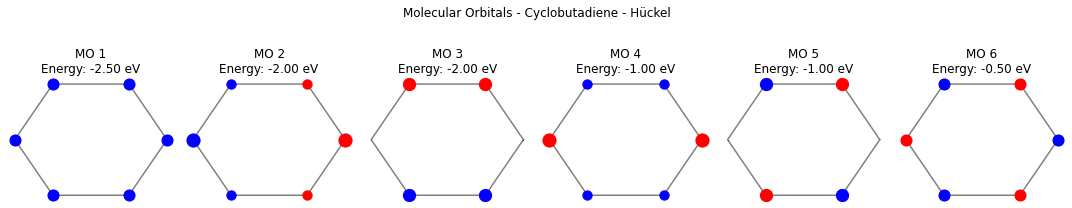

In [16]:
from class_huckel import huckel
benzene = huckel(6, -1.5, -0.5)
benzene.create_matrix()

huc_mat = benzene.huckel_matrix
print(huc_mat)
benzene.create_parametric_matrix_and_eigenvalues()
print(benzene.eigval_para_latex)
benzene.solve_huckel_matrix()
print(benzene.multiplicities)
print(benzene.eigenvectors)
print(benzene.eigenvalues)
print(benzene.eigval_para)
print(huc_mat)
benzene.plotting_of_the_system()

